# 회귀 알고리즘을 사용한 다층신경망 구축

In [ ]:
import numpy as np # 선형대수학
import pandas as pd # 데이터 전처리 , CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns 
from warnings import filterwarnings 
filterwarnings('ignore')  # 경고메세지 무시하기

In [ ]:
df = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
print("Train dataset shape :", df.shape)
print("Test dateset shape :", test.shape)

Train dataset shape : (8693, 14)
Test dateset shape : (4277, 13)


In [ ]:
def pre_processing(data) :
    # PassengerId 컬럼 Group, Group_num 컬럼으로 분리
    data[['Group', 'Group_num']] = data['PassengerId'].str.split("_", expand=True)
    
    # Name 컬럼 First, Last로 분리
    data[['First', 'Last']] = data['Name'].str.split(" ", expand=True)
    
    # HomePlanet, CryoSleep, Destination, VIP 컬럼 결측치에 최빈값 입력
    for feature in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'] :
        data[feature].fillna(data[feature].mode()[0], inplace=True)
    
    # Age 결측치에 HomePlanet, CryoSleep, Destination, VIP 컬럼별 평균값 입력
    data['Age'] = data['Age'].fillna(data.groupby(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'])['Age'].transform('mean'))
    
    # Group_num을 Group별 Group_num의 최대값으로 대체 (그룹 총 인원)
    data['Group_num'] = data.groupby('Group')['Group_num'].transform('max').apply(int)
    
    #Group별 Last가 같은 데이터의 개수를 값으로 갖는 Family_num 컬럼으로 생성 (그룹 내 가족 수)
    data['Family_num'] = data.groupby(['Group', 'Last'])['Last'].transform('count')
    # Family_num 결측치인 데이터는 대부분 혼자 온 사람들이므로 결측치에 1 대입
    data['Family_num'].fillna(1, inplace=True)
    data['Family_num'] = data['Family_num'].apply(int)
    
    # RoomService, FoodCourt, ShoppingMall, Spa, VRDeck 컬럼 결측치에 0 입력
    for feature in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] :
        data[feature].fillna(0, inplace=True)
   
    # Cabin 컬럼은 deck, num, side로 분리해서 컬럼 생성
    data[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = data['Cabin'].str.split("/", expand=True)
    # Cabin_deck, Cabin_side 컬럼 결측치에 unknown 입력
    data[['Cabin_deck', 'Cabin_side']] = data[['Cabin_deck', 'Cabin_side']].fillna('unknown')
    # PassengerId, Cabin, Name, Group, First, Last, Cabin_num 컬럼 삭제
    data.drop(['PassengerId', 'Cabin', 'Name', 'Group', 'First', 'Last', 'Cabin_num'], axis=1, inplace=True)

    # Transported 변수 True = 1, False = 0 변환
    data['Transported'] = data['Transported'].apply(lambda x : 1 if x == True else 0)

    data.columns = data.columns.str.lower()

    return data

In [ ]:
df = pre_processing(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   homeplanet    8693 non-null   object 
 1   cryosleep     8693 non-null   bool   
 2   destination   8693 non-null   object 
 3   age           8693 non-null   float64
 4   vip           8693 non-null   bool   
 5   roomservice   8693 non-null   float64
 6   foodcourt     8693 non-null   float64
 7   shoppingmall  8693 non-null   float64
 8   spa           8693 non-null   float64
 9   vrdeck        8693 non-null   float64
 10  transported   8693 non-null   int64  
 11  group_num     8693 non-null   int64  
 12  family_num    8693 non-null   int64  
 13  cabin_deck    8693 non-null   object 
 14  cabin_side    8693 non-null   object 
dtypes: bool(2), float64(6), int64(3), object(4)
memory usage: 900.0+ KB


In [ ]:
df.head()

,homeplanet,cryosleep,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,group_num,family_num,cabin_deck,cabin_side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,1,1,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,1,1,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,2,2,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,2,2,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,1,1,F,S


In [ ]:
#@title StratifiedShuffleSplit 계층적 샘플링
# train_test_split은 무작위로 섞어서 split한다
# StratifiedShuffleSplit는 비율을 유지하면서 split한다
# 훈련데이터셋에서 검증데이터셋을 쪼개준다

# 
from sklearn.model_selection import StratifiedShuffleSplit 
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, val_index in sss.split(df, df['homeplanet']):
    train_data = df.iloc[train_index]
    val_data = df.iloc[val_index]

In [ ]:
print("Train data shape after sss:", train_data.shape)
print("Validation data shape:", val_data.shape)

Train data shape after sss: (7823, 15)
Validation data shape: (870, 15)


In [ ]:
# 나머지 범주형 변수 원-핫 인코딩
train_data = pd.get_dummies(train_data, columns=['homeplanet', 'destination',
                                                     'cabin_deck', 'cabin_side', 'cryosleep', 'vip'],
                                 drop_first=True)
val_data =  pd.get_dummies(val_data, columns=['homeplanet', 'destination', 
                                                  'cabin_deck', 'cabin_side', 'cryosleep', 'vip'],
                                drop_first=True)

In [ ]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,7823.0,28.810174,14.280027,0.0,20.0,27.0,37.0,79.0
roomservice,7823.0,224.902595,664.966085,0.0,0.0,0.0,46.0,14327.0
foodcourt,7823.0,450.384891,1607.316793,0.0,0.0,0.0,61.5,29813.0
shoppingmall,7823.0,168.931484,594.156991,0.0,0.0,0.0,23.0,23492.0
spa,7823.0,308.860028,1130.848861,0.0,0.0,0.0,56.0,22408.0
vrdeck,7823.0,304.235460,1161.540805,0.0,0.0,0.0,40.0,24133.0
transported,7823.0,0.500703,0.500031,0.0,0.0,1.0,1.0,1.0
group_num,7823.0,2.034641,1.596452,1.0,1.0,1.0,3.0,8.0
family_num,7823.0,1.774511,1.270812,1.0,1.0,1.0,2.0,8.0
homeplanet_Europa,7823.0,0.245174,0.430218,0.0,0.0,0.0,0.0,1.0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7823 entries, 899 to 4872
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        7823 non-null   float64
 1   roomservice                7823 non-null   float64
 2   foodcourt                  7823 non-null   float64
 3   shoppingmall               7823 non-null   float64
 4   spa                        7823 non-null   float64
 5   vrdeck                     7823 non-null   float64
 6   transported                7823 non-null   int64  
 7   group_num                  7823 non-null   int64  
 8   family_num                 7823 non-null   int64  
 9   homeplanet_Europa          7823 non-null   uint8  
 10  homeplanet_Mars            7823 non-null   uint8  
 11  destination_PSO J318.5-22  7823 non-null   uint8  
 12  destination_TRAPPIST-1e    7823 non-null   uint8  
 13  cabin_deck_B               7823 non-null   uin

In [ ]:
# 중복값 확인
train_data.duplicated().sum()

776

In [ ]:
train_data.isnull().sum()

age                          0
roomservice                  0
foodcourt                    0
shoppingmall                 0
spa                          0
vrdeck                       0
transported                  0
group_num                    0
family_num                   0
homeplanet_Europa            0
homeplanet_Mars              0
destination_PSO J318.5-22    0
destination_TRAPPIST-1e      0
cabin_deck_B                 0
cabin_deck_C                 0
cabin_deck_D                 0
cabin_deck_E                 0
cabin_deck_F                 0
cabin_deck_G                 0
cabin_deck_T                 0
cabin_deck_unknown           0
cabin_side_S                 0
cabin_side_unknown           0
cryosleep_True               0
vip_True                     0
dtype: int64

In [ ]:
train_data

,age,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,group_num,family_num,homeplanet_Europa,...,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T,cabin_deck_unknown,cabin_side_S,cabin_side_unknown,cryosleep_True,vip_True
899,44.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0,...,0,0,1,0,0,0,0,0,1,0
2202,21.0,0.0,0.0,0.0,0.0,0.0,1,3,3,0,...,1,0,0,0,0,0,1,0,1,0
3223,16.0,0.0,0.0,0.0,0.0,0.0,1,2,2,0,...,0,0,0,1,0,0,1,0,1,0
2686,36.0,418.0,40.0,7.0,338.0,0.0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
3117,9.0,0.0,0.0,0.0,0.0,0.0,1,4,3,0,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,27.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,...,0,0,0,0,0,0,1,0,1,0
6703,1.0,0.0,0.0,0.0,0.0,0.0,1,2,2,0,...,0,0,0,1,0,0,1,0,1,0
7977,23.0,348.0,210.0,0.0,0.0,1.0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
6404,32.0,2937.0,60.0,696.0,0.0,0.0,0,2,2,0,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
#@title 데이터셋 준비

# 알파벳 순으로 컬럼 정렬
train_data = train_data.reindex(sorted(train_data.columns), axis=1)

In [ ]:
train_data.head()

,age,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T,cabin_deck_unknown,cabin_side_S,...,foodcourt,group_num,homeplanet_Europa,homeplanet_Mars,roomservice,shoppingmall,spa,transported,vip_True,vrdeck
899,44.0,0,0,0,0,1,0,0,0,0,...,0.0,1,0,1,0.0,0.0,0.0,1,0,0.0
2202,21.0,0,0,1,0,0,0,0,0,1,...,0.0,3,0,1,0.0,0.0,0.0,1,0,0.0
3223,16.0,0,0,0,0,0,1,0,0,1,...,0.0,2,0,0,0.0,0.0,0.0,1,0,0.0
2686,36.0,0,0,0,0,1,0,0,0,0,...,40.0,1,0,0,418.0,7.0,338.0,0,0,0.0
3117,9.0,0,0,0,0,1,0,0,0,1,...,0.0,4,0,1,0.0,0.0,0.0,1,0,0.0


In [ ]:
#@title 데이터셋과 타겟데이터 분리
X_data = train_data.drop("transported", axis=1).values
y_data = train_data["transported"].values.reshape(-1,1)

In [ ]:
#@title 훈련셋을 훈련데이터와 검증데이터로 분리
# 여기서의 검증데이터는 초기에 나눈 검증셋(val_data)과는 다르다
from sklearn.model_selection import train_test_split 
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data,
                                                  test_size=0.1,
                                                  random_state=42)

print('for train dataset:')
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\nfor validation dataset:')
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

for train dataset:
X_train shape: (7040, 24)
y_train shape: (7040, 1)

for validation dataset:
X_val shape: (783, 24)
y_val shape: (783, 1)


In [ ]:
# SimpleImputer : missing value를 특정값으로 채우는 라이브러리
# MinMaxScaler로 정규화
# pipeline : 전처리하는 모델을 한데 엮어서 쓸수있게 한다
from sklearn.preprocessing import MinMaxScaler 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
pipeline = Pipeline([
    ("scaler", MinMaxScaler(feature_range=(0,1)))
])
X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)

In [ ]:
#@title 모델링
# 파라미터 설정
input_shape = X_train.shape[1]
batch_size = 32
epoch = 500
verbose = 1
weights_dir = "best_weights.h5"
monitor = "val_loss"
patience = 20

In [ ]:
# Building Model
from tensorflow.keras import models as m, layers as l, callbacks as cb, optimizers as opt 

model = m.Sequential([ 
    l.Input(input_shape),
    l.Flatten(),

    l.BatchNormalization(), 
    l.Dense(256, kernel_initializer="he_uniform", activation='relu'),
    l.Dropout(0.3),

    l.BatchNormalization(),
    l.Dense(128, kernel_initializer="he_uniform", activation="relu"),
    l.Dropout(0.3),

    l.BatchNormalization(),
    l.Dense(64, kernel_initializer="he_uniform", activation="relu"),
    l.Dropout(0.3),

    l.BatchNormalization(),
    l.Dense(1, activation="sigmoid")
])
# kernel_initializer="he_uniform" : He 균등분포 분산 스케일링 초기값 설정기.

In [ ]:
# Compiling Model
model.compile(optimizer= opt.RMSprop(learning_rate=0.003),
              loss = "binary_crossentropy",
              metrics=["accuracy"])

# Getting Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 24)                0         
                                                                 
 batch_normalization (BatchN  (None, 24)               96        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               6400      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)               3

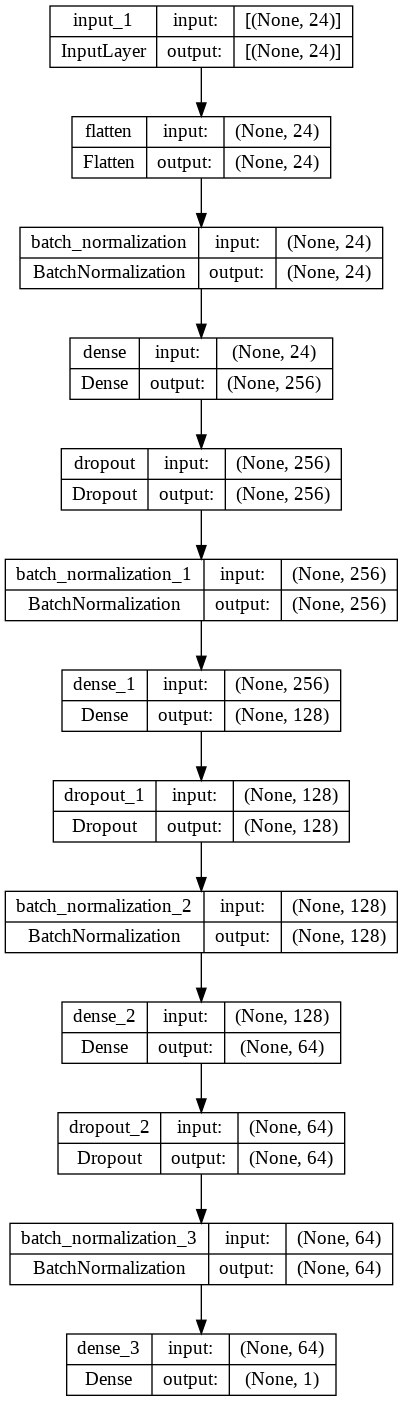

In [ ]:
from tensorflow.keras.utils import plot_model 
plot_model(model, show_shapes=True)

In [ ]:
#@title 콜백 세팅
checkpoint = cb.ModelCheckpoint(weights_dir, 
                                save_best_only=True, 
                                monitor=monitor)
early_stopping = cb.EarlyStopping(patience=patience,
                                  restore_best_weights=True, 
                                  monitor=monitor)

In [ ]:
#@title model training
hist = model.fit(X_train, y_train, batch_size=batch_size, 
                 epochs=epoch, 
                 validation_data=(X_val, y_val), 
                 callbacks=[checkpoint, early_stopping], 
                 verbose=verbose)
print("Training finished.")

# Load best weights
real_epoch = len(hist.history['accuracy']) 
if real_epoch < epoch:
    print("Best weights loading..")
    model.load_weights(weights_dir)
    print("Loaded.")

Epoch 1/500
220/220 [==============================] - 2s 3ms/step - loss: 0.5284 - accuracy: 0.7402 - val_loss: 0.5086 - val_accuracy: 0.7139
Epoch 2/500
220/220 [==============================] - 0s 2ms/step - loss: 0.4644 - accuracy: 0.7699 - val_loss: 0.4762 - val_accuracy: 0.7471
Epoch 3/500
220/220 [==============================] - 1s 2ms/step - loss: 0.4460 - accuracy: 0.7866 - val_loss: 0.4268 - val_accuracy: 0.7854
Epoch 4/500
220/220 [==============================] - 1s 2ms/step - loss: 0.4447 - accuracy: 0.7891 - val_loss: 0.4141 - val_accuracy: 0.7918
Epoch 5/500
220/220 [==============================] - 0s 2ms/step - loss: 0.4380 - accuracy: 0.7908 - val_loss: 0.4198 - val_accuracy: 0.7842
Epoch 6/500
220/220 [==============================] - 0s 2ms/step - loss: 0.4385 - accuracy: 0.7895 - val_loss: 0.4302 - val_accuracy: 0.7982
Epoch 7/500
220/220 [==============================] - 0s 2ms/step - loss: 0.4398 - accuracy: 0.7928 - val_loss: 0.4251 - val_accuracy: 0.7829

In [ ]:
#@title 모델 성능 평가

train_loss, train_acc = model.evaluate(X_train, y_train)
val_loss, val_acc = model.evaluate(X_val, y_val)

train_loss, train_cc = np.round(train_loss, 5), np.round(train_acc, 5)
val_loss, val_acc = np.round(val_loss, 5), np.round(val_acc, 5)

print("\n Train loss:", train_loss)
print("Train accuracy:", train_acc)
print("-----------------------------------")
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

25/25 [==============================] - 0s 1ms/step - loss: 0.4072 - accuracy: 0.8072

 Train loss: 0.3913
Train accuracy: 0.8126420378684998
-----------------------------------
Validation loss: 0.40724
Validation accuracy: 0.80715


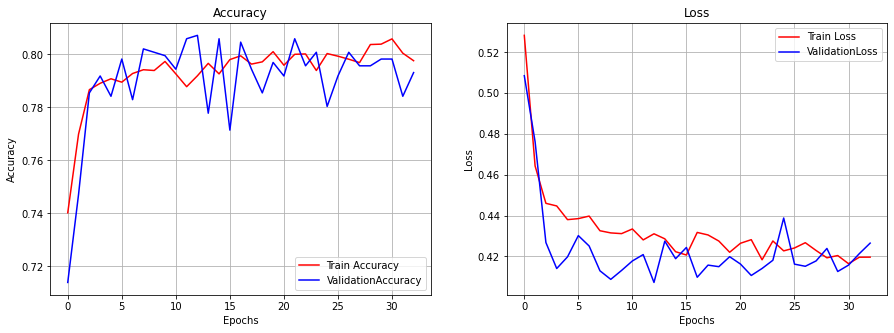

In [ ]:
#@title 시각화
def plot_result(metrics):
    epoch = range(len(hist.history[metrics]))
    plt.plot(epoch, hist.history[metrics], "r", label=f"Train {metrics.title()}")
    plt.plot(epoch, hist.history[f"val_{metrics}"], "b", label=f"Validation{metrics.title()}")
    plt.title(f"{metrics.title()}")
    plt.xlabel("Epochs")
    plt.ylabel(f"{metrics.title()}")
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(15,5)) 
plt.subplot(1,2,1)
# accruacy plot
plot_result("accuracy")
# loss plot
plt.subplot(1,2,2)
plot_result("loss")



In [ ]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
#@title X_train,X_val 데이터로 predict
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

pred_train = np.round(pred_train)
pred_val = np.round(pred_val)

25/25 [==============================] - 0s 965us/step


In [ ]:
#@title 평가지표 확인
train_cr = classification_report(y_train, pred_train)
print("Train classification report:\n\n", train_cr)

Train classification report:

               precision    recall  f1-score   support

           0       0.82      0.80      0.81      3530
           1       0.80      0.82      0.81      3510

    accuracy                           0.81      7040
   macro avg       0.81      0.81      0.81      7040
weighted avg       0.81      0.81      0.81      7040



In [ ]:
val_cr = classification_report(y_val, pred_val) 
print("Validation classification report:\n\n", val_cr)

Validation classification report:

               precision    recall  f1-score   support

           0       0.80      0.80      0.80       376
           1       0.81      0.82      0.82       407

    accuracy                           0.81       783
   macro avg       0.81      0.81      0.81       783
weighted avg       0.81      0.81      0.81       783



In [ ]:
#@title 성능 평가 지표 한 눈에 보기 위한 사용자 정의 함수
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def eval_model(y_test, pred, model=None):
  # accuracy score 출력
  print(f"accuracy_score : {accuracy_score(y_test, pred):.6f}")
  # model 입력 했으면 roc auc score 출력
  if model :
    pred_proba = model.predict_proba(X_test)[:, 1]
    print(f"roc-auc score  : {roc_auc_score(y_test, pred_proba):.6f}")
  else :
    print("roc-auc score  : need model")
  print()
  # confusion matrix 출력
  print("-- confusion matrix --")
  cf_matrix = confusion_matrix(y_test, pred)
  group_names = ['TN', 'FP', 'FN', 'TP']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()
  print()
  # 1종, 2종 오류 확률 출력
  print(f"type I error probabilty  : {cf_matrix[0][1]/(cf_matrix[0][1]+cf_matrix[1][1]):.6f}")
  print(f"type II error probabilty : {cf_matrix[1][0]/(cf_matrix[1][0]+cf_matrix[0][0]):.6f}")
  print()
  print()
  # 정밀도, 재현율 F1-score 등 출력
  print("-- classification report --")
  print(classification_report(y_test, pred))

accuracy_score : 0.807152
roc-auc score  : need model

-- confusion matrix --


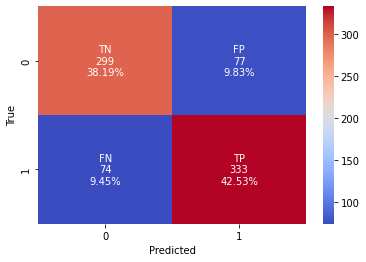


type I error probabilty  : 0.187805
type II error probabilty : 0.198391


-- classification report --
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       376
           1       0.81      0.82      0.82       407

    accuracy                           0.81       783
   macro avg       0.81      0.81      0.81       783
weighted avg       0.81      0.81      0.81       783



In [ ]:
eval_model(y_val, pred_val)

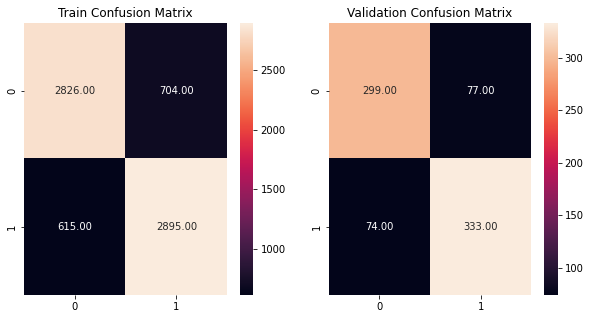

In [ ]:
# 결과지표
train_cm = confusion_matrix(y_train, pred_train)
val_cm = confusion_matrix(y_val, pred_val)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(train_cm, annot=True, fmt=".2f")
plt.title("Train Confusion Matrix")
plt.subplot(1,2,2)
sns.heatmap(val_cm, annot=True, fmt=".2f")
plt.title("Validation Confusion Matrix");

In [ ]:
val_data.columns

Index(['age', 'roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck',
       'transported', 'group_num', 'family_num', 'homeplanet_Europa',
       'homeplanet_Mars', 'destination_PSO J318.5-22',
       'destination_TRAPPIST-1e', 'cabin_deck_B', 'cabin_deck_C',
       'cabin_deck_D', 'cabin_deck_E', 'cabin_deck_F', 'cabin_deck_G',
       'cabin_deck_unknown', 'cabin_side_S', 'cabin_side_unknown',
       'cryosleep_True', 'vip_True'],
      dtype='object')

In [ ]:
#@title 검증데이터 확인
val_data_model = val_data.copy()
valid_X = pipeline.transform(val_data_model)   
valid_X = val_data_model.drop("transported", axis=1).values
valid_y = val_data_model.transported.values.reshape(-1,1)

In [ ]:
valid_X

array([[3.400e+01, 0.000e+00, 2.612e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.400e+01, 1.242e+03, 4.440e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.400e+01, 3.400e+01, 2.230e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [4.400e+01, 2.200e+01, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.600e+01, 8.500e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.200e+01, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [ ]:
valid_y.shape

(870, 1)

In [ ]:
results = model.evaluate(valid_X, valid_y)
results

InvalidArgumentError: ignored

In [ ]:
#@title 테스트데이터 확인
test_data_model = test.copy()
test_data_model = pre_processing(test_data_model)
X_test = test_data_model.values
X_test = pipeline.transform(X_test)

In [ ]:
pred = model.predict(X_test)
y_pred = np.round(pred)
submission_data = pd.DataFrame(columns=["PassengerId", "Transported"])
submission_data["PassengerId"]= test_data_model.index
submission_data["Transported"]= [True if x==1. else False for x in y_pred]